In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [29]:
np.random.seed(9999)

In [30]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [31]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [32]:
#generate corrupted mnist images by adding noise with normal dist
#centered at 0.5 and std = 0.5
noise = np.random.normal(loc = 0.5, scale = 0.5, size = x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc = 0.5, scale = 0.5, size = x_test.shape)
x_test_noisy = x_test + noise

In [33]:
#adding noise may exceed normalized pixel value >1.0 and <0.0
#clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [34]:
#network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
#encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [35]:
#build the autoencoder model
#first build the encoder model
inputs = Input(shape=input_shape, name = 'encoder_input')
x = inputs
#stack for Conv2D(32) - Conv2D(64)
for filters in layer_filters:
  x = Conv2D(filters = filters,
             kernel_size = kernel_size,
             padding = 'same',
             strides = 2,
             activation = 'relu')(x)

shape = K.int_shape(x)

#generate the talent vector
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)
#instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [36]:
#build the decoder model
latent_inputs = Input(shape=(latent_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
#stack for Conv2DTranspose(64) - Conv2DTranspose(32)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
                      kernel_size = kernel_size,
                      padding = 'same',
                      strides = 2,
                      activation = 'relu')(x)
#recontruct the denoised decoder
outputs = Conv2DTranspose(filters=1,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid',
                          name = 'decoder_output')(x)

#instantiate for decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [37]:
#build autoencoder = encoder + decoder
#instantiate for autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [38]:
#compile the model
#Loss function : MSE, Optimizer : Adam
autoencoder.compile(loss='mse', optimizer='adam')

In [39]:
#train the autoencoder model
autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=10, batch_size=batch_size, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0361 - val_loss: 0.0211
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0193 - val_loss: 0.0182
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0155 - val_loss: 0.0159
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0153 - val_loss: 0.0160
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.015

In [40]:
#predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

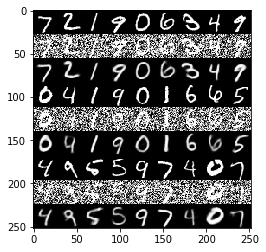

In [41]:
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()